In [2]:
import numpy as np
import os
from math import sqrt

from pims import ImageSequence
from skimage.color import rgb2grey
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.measure import find_contours

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
def load_data(filepath):
    
    fileparts = filepath.split('/')
    imagepath = os.path.join(filepath, '*.tif')
    textpath = os.path.join(filepath, '{}.txt'.format(fileparts[-2]))

    images = ImageSequence(imagepath, as_grey=True)

    with open(textpath, 'r', encoding='UTF-8') as f:
        info = f.readlines()
    
    return images, info

images, info = load_data(filepath='../Data/Atta/CG379_14_63xZ2_Ca_li/')

In [5]:
def grey_sequence(rgb_sequence):
    
    grey_images = []
    
    for image in rgb_sequence:
        grey_image = rgb2grey(image)
        grey_images.append(grey_image)
    
    return grey_images

grey_images = grey_sequence(images)

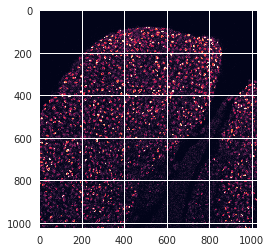

In [6]:
plt.imshow(grey_images[4]);

In [7]:
def extract_voxel(info):
    voxel_size = 0
    voxel_depth = 0
    
    for line in info:
        if 'Voxel-Height' in line.split():
            voxel_size = float(line.split()[-1][:-1])

        if 'Voxel-Depth' in line.split():
            voxel_depth = float(line.split()[-1][:-1])
    
    return voxel_size, voxel_depth  

voxel_size, voxel_depth = extract_voxel(info)

In [8]:
def crop_images(grey_sequence, voxel_size, y_start=400, x_start=200):

    cropped_images = []
    pixel_number = 10/voxel_size
    print(pixel_number)
    y_stop = int(y_start + pixel_number)
    x_stop = int(x_start + pixel_number)

    for image in grey_images:
        cropped_image = image[y_start:y_stop, x_start:x_stop]
        cropped_images.append(cropped_image)
    
    return cropped_images

cropped_sequence = crop_images(grey_images, voxel_size=voxel_size)

86.01632589865557


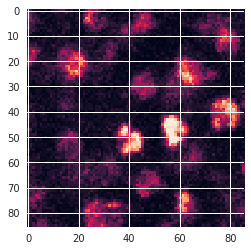

In [9]:
plt.imshow(cropped_sequence[5])
plt.show()

In [10]:
def adjust_contrast(cropped_images, lower_threshold=15000, upper_threshold=30000):
    final_images = []
    
    for image in cropped_images:
        new_image = image.copy()
        new_image[new_image < lower_threshold] = 0
        new_image[new_image > upper_threshold] = 100000
        final_images.append(new_image)
    
    return final_images

final_series = adjust_contrast(cropped_images=cropped_sequence, lower_threshold=20000)

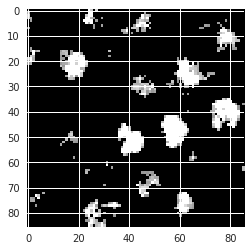

In [12]:
plt.imshow(final_series[5], cmap='gray')
plt.show()

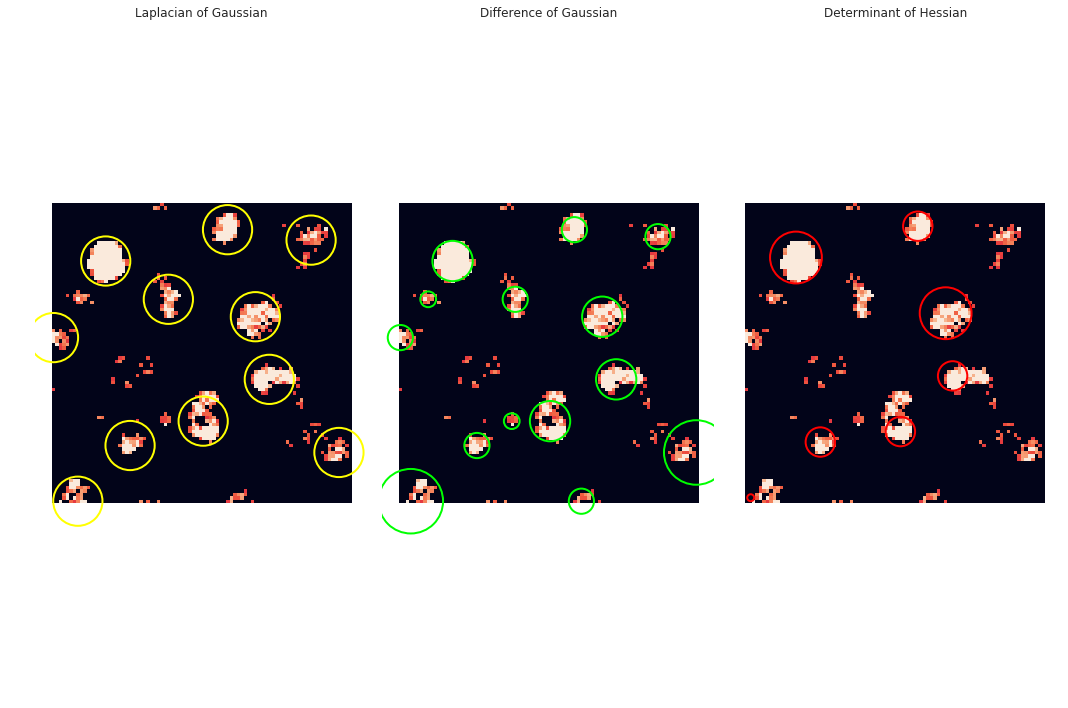

In [24]:
image_gray = final_series[10]
blobs_log = blob_log(image_gray, min_sigma=5, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=10, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image_gray, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()


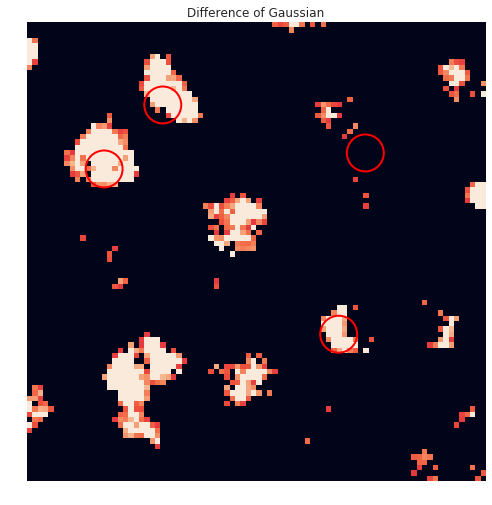

In [14]:
def make_blobs_dog(image_sequence=final_series, z_layer=0):
    
    blobs = blob_dog(image_sequence, min_sigma=2, max_sigma=50, sigma_ratio=4, threshold=.5, overlap=0)
    blobs[:, 3] = blobs[:, 3] * sqrt(3)
    
    blobs_0 = blobs[blobs[:, 0] == z_layer]
    fig, ax = plt.subplots(1, 1, figsize=(7, 15))

    ax.set_title('Difference of Gaussian')
    ax.imshow(image_sequence[z_layer], interpolation='nearest')
    for blob in blobs_0:
        p, x, y, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        ax.add_patch(c)
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()

make_blobs_dog(z_layer=0)

6


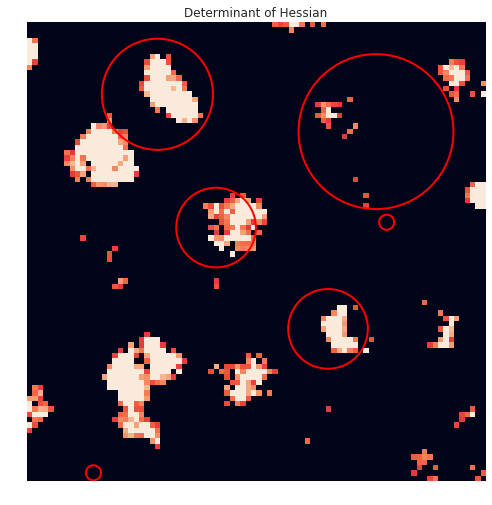

In [12]:
def make_blobs_doh(image_sequence=final_series, z_layer=0):
    
    blobs = blob_doh(image_sequence[z_layer], min_sigma=1, max_sigma=20, threshold=.009, log_scale=True, overlap=0)
    blobs[:, 2] = blobs[:, 2] * sqrt(2)
    print(len(blobs))
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 15))

    ax.set_title('Determinant of Hessian')
    ax.imshow(image_sequence[z_layer], interpolation='nearest')
    for blob in blobs:
        x, y, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        ax.add_patch(c)
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()

make_blobs_doh()

In [13]:
final_series[0]

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ..., 24320,     0,     0],
       [    0,     0,     0, ...,     0,     0, 22528],
       [    0,     0,     0, ...,     0, 22272,     0]], dtype=uint16)

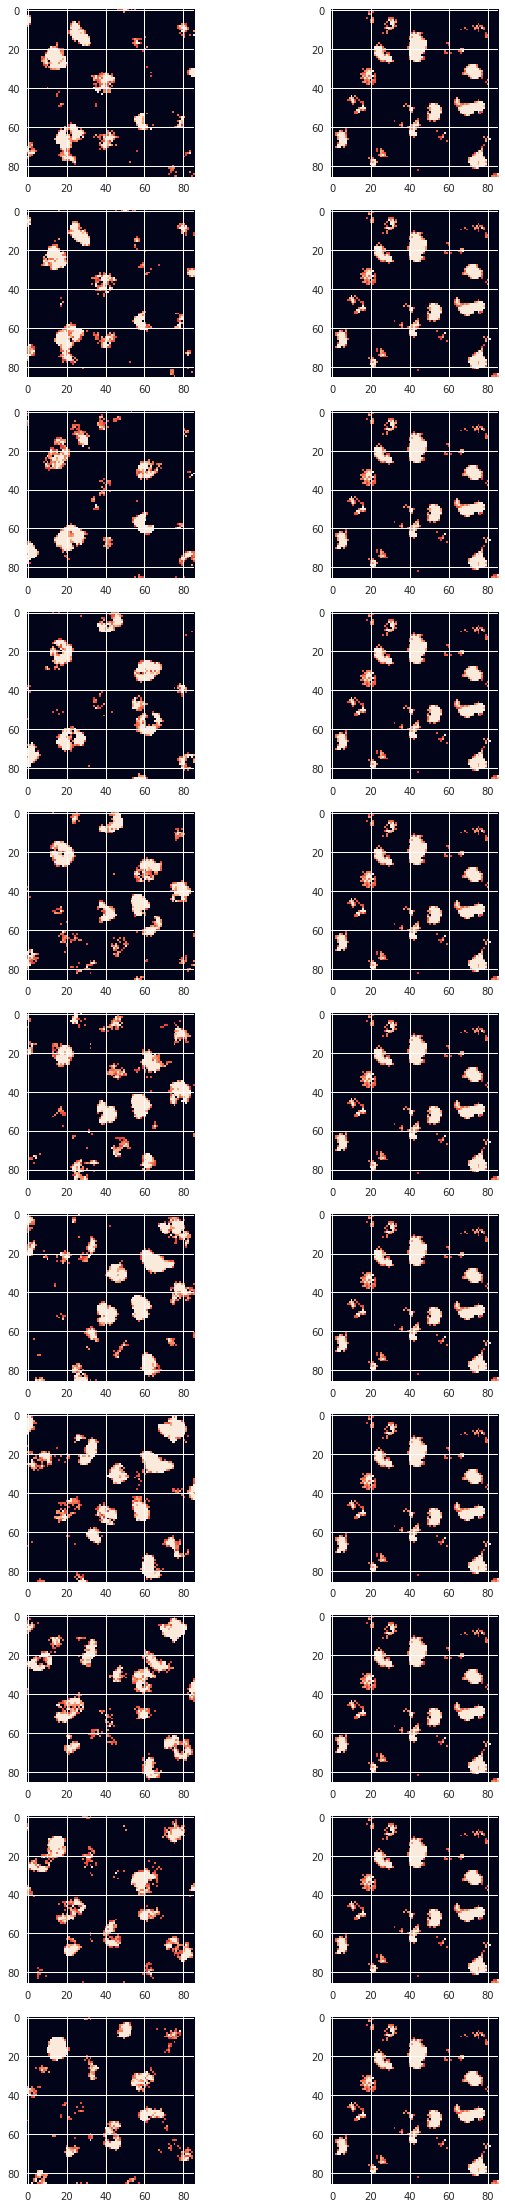

In [14]:
series_lengths = int(len(final_series))
rows = int(series_lengths/2)
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10,40))
for layer in range(series_lengths-1):
    if (layer * 2) < series_lengths:
        ax[layer, 0].imshow(final_series[layer])
    else:
        for index in range(int(series_lengths/2)):
            ax[index, 1].imshow(final_series[layer])

In [15]:
coordinates = []
for (x,y), value in np.ndenumerate(final_series[0]):
    if value > 0:
        coordinates.append((x, y))

In [31]:
contours = find_contours(final_series[0], 0)

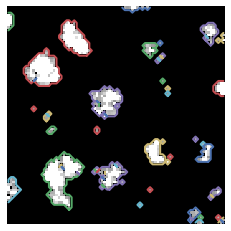

In [32]:
fig, ax = plt.subplots()
ax.imshow(final_series[0], cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()